In [1]:
import numpy as np
import gym
import random
from collections import deque
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

Using TensorFlow backend.


**DQN Agent**

In [2]:
class DQNAgent:
    def __init__(self, env):
      self.env = env
      self.observation_space = env.observation_space
      self.action_space = env.action_space
      self.size_of_state = self.observation_space.shape[0]
      self.number_of_actions = self.action_space.n
      
      self.memory = deque(maxlen=50000)
      self.gamma = 0.9
      self.epsilon_max = 1.0
      self.epsilon_min = 0.001
      self.epsilon_decay = 0.9 #Modified to 0.95 and results added to report
      self.batch_size = 32
      self.epsilon = self.epsilon_max
      self.epsilon_history = [self.epsilon]
      self.reward_history = []
      self.average_reward_history = []

      self.model = self.build_model()
      self.target_model = self.build_model()
      self.sync_target()

    def build_model(self):
      model = Sequential()
      model.add(Dense(24, input_dim=self.size_of_state, activation='relu'))
      model.add(Dense(24, activation='relu'))
      model.add(Dense(self.number_of_actions, activation='linear'))
      model.compile(loss='mse', optimizer=Adam(lr=0.001))
      return model

    def step(self, state):
      if self.epsilon > np.random.rand():
        action = np.random.choice(self.number_of_actions)
      else:
        action = np.argmax(self.model.predict(state)[0])
      return action
      
    def sync_target(self):
      self.target_model.set_weights(self.model.get_weights())

    def replay(self):
      if len(self.memory) < self.batch_size:
        return      
      sample_batch = random.sample(self.memory, self.batch_size)
      
      for state, action, reward, state_prime, done in sample_batch:
          state_target = self.target_model.predict(state)
          if done:
            state_target[0][action] = reward
          else:
            Q_prime = max(self.target_model.predict(state_prime)[0])
            state_target[0][action] = reward + self.gamma*Q_prime
          self.model.fit(state, state_target, epochs = 1, verbose = 0)

    def update_epsilon(self):
      #Update epsilon
      self.epsilon*= self.epsilon_decay
      self.epsilon = max(self.epsilon,self.epsilon_min)
      self.epsilon_history.append(self.epsilon)

        

**CartPole using DQN Agent**

In [3]:
class Environment:
    def __init__(self):
      self.env = gym.make('CartPole-v1')
      self.dqnAgent = DQNAgent(self.env)
      self.observation_space = self.env.observation_space
      self.action_space = self.env.action_space
      self.size_of_state = self.observation_space.shape[0]
      self.number_of_actions = self.action_space.n
      self.number_of_episodes = 500 #Modified to 1000 and results added to report
      self.C = 1 #Modified to 5 and 10 and results added to report
      self.reward_average_episodes = 10
      

    def train(self):
      for episode in range(self.number_of_episodes):
        state = self.env.reset()
        state = state.reshape(1,self.size_of_state)
        done = False
        episode_reward = 0
        while not done:
            action = self.dqnAgent.step(state)
            state_prime, reward, done, info = self.env.step(action)
            episode_reward+=reward
            state_prime = state_prime.reshape(1,self.size_of_state)
            self.dqnAgent.memory.append([state, action, reward, state_prime, done])
            state = state_prime
        self.dqnAgent.replay()
        self.dqnAgent.update_epsilon()
        self.dqnAgent.reward_history.append(episode_reward)
        print("Episode: {}, episode_reward: {}".format(episode, episode_reward))
        if episode > self.reward_average_episodes:
          self.dqnAgent.average_reward_history.append(sum(self.dqnAgent.reward_history[-self.reward_average_episodes:])/self.reward_average_episodes)

        if episode % self.C == 0:
          self.dqnAgent.sync_target()

In [4]:
env = Environment()
env.train()

Episode: 0, episode_reward: 11.0
Episode: 1, episode_reward: 72.0
Episode: 2, episode_reward: 21.0
Episode: 3, episode_reward: 17.0
Episode: 4, episode_reward: 21.0
Episode: 5, episode_reward: 28.0
Episode: 6, episode_reward: 12.0
Episode: 7, episode_reward: 31.0
Episode: 8, episode_reward: 14.0
Episode: 9, episode_reward: 18.0
Episode: 10, episode_reward: 11.0
Episode: 11, episode_reward: 11.0
Episode: 12, episode_reward: 13.0
Episode: 13, episode_reward: 9.0
Episode: 14, episode_reward: 10.0
Episode: 15, episode_reward: 12.0
Episode: 16, episode_reward: 8.0
Episode: 17, episode_reward: 9.0
Episode: 18, episode_reward: 10.0
Episode: 19, episode_reward: 11.0
Episode: 20, episode_reward: 10.0
Episode: 21, episode_reward: 11.0
Episode: 22, episode_reward: 12.0
Episode: 23, episode_reward: 24.0
Episode: 24, episode_reward: 19.0
Episode: 25, episode_reward: 12.0
Episode: 26, episode_reward: 10.0
Episode: 27, episode_reward: 9.0
Episode: 28, episode_reward: 12.0
Episode: 29, episode_reward:

**Double DQN(DDQN) Agent**

In [5]:
class DDQNAgent:
    def __init__(self, env):
      self.env = env
      self.observation_space = env.observation_space
      self.action_space = env.action_space
      self.size_of_state = self.observation_space.shape[0]
      self.number_of_actions = self.action_space.n
      
      self.memory = deque(maxlen=50000)
      self.gamma = 0.9
      self.epsilon_max = 1.0
      self.epsilon_min = 0.001
      self.epsilon_decay = 0.9 #Modified to 0.95 and results added to report
      self.batch_size = 32
      self.tau = 0.99
      self.epsilon = self.epsilon_max
      self.epsilon_history = [self.epsilon]
      self.reward_history = []
      self.average_reward_history = []

      #self.saved_model = "saved_model.h5"
      self.model = self.build_model()
      self.target_model = self.build_model()
      self.sync_target()


    def build_model(self):
      model = Sequential()
      model.add(Dense(24, input_dim=self.size_of_state, activation='relu'))
      model.add(Dense(24, activation='relu'))
      model.add(Dense(self.number_of_actions, activation='linear'))
      model.compile(loss='mse', optimizer=Adam(lr=0.001))
      return model

    def step(self, state):
      if self.epsilon > np.random.rand():
        action = np.random.choice(self.number_of_actions)
      else:
        action = np.argmax(self.model.predict(state)[0]) 
      return action
      
    def sync_target(self):
      model_weights = self.model.get_weights()
      target_weights = self.target_model.get_weights()
      for i, (model_weight, target_weight) in enumerate(zip(model_weights, target_weights)):
        target_weights[i] =  model_weight*self.tau + target_weight * (1-self.tau) 
      self.target_model.set_weights(target_weights)

    def replay(self):
      if len(self.memory) < self.batch_size:
        return
      sample_batch = random.sample(self.memory, self.batch_size)
      
      for state, action, reward, state_prime, done in sample_batch:
        state_target = self.model.predict(state)
        if done:
          state_target[0][action] = reward
        else:
          best_action = np.argmax(self.model.predict(state_prime)[0])
          Q_prime = self.target_model.predict(state_prime)[0][best_action]
          state_target[0][action] = reward + self.gamma*Q_prime
        self.model.fit(state, state_target, epochs = 1, verbose = 0)

    def update_epsilon(self):
      #Update epsilon
      self.epsilon*= self.epsilon_decay
      self.epsilon = max(self.epsilon,self.epsilon_min)
      self.epsilon_history.append(self.epsilon)



**CartPole using DDQN Agent**

In [6]:
class dEnvironment:
    def __init__(self):
      self.env = gym.make('CartPole-v1')
      self.dqnAgent = DDQNAgent(self.env)
      self.observation_space = self.env.observation_space
      self.action_space = self.env.action_space
      self.size_of_state = self.observation_space.shape[0]
      self.number_of_actions = self.action_space.n
      self.number_of_episodes = 500 #Modified to 1000 and results added to report
      self.C = 1 #Modified to 5 and 10 and results added to report
      self.reward_average_episodes = 10
      

    def train(self):
      for episode in range(self.number_of_episodes):
        state = self.env.reset()
        state = state.reshape(1,self.size_of_state)
        done = False
        episode_reward = 0
        while not done:
            action = self.dqnAgent.step(state)
            state_prime, reward, done, info = self.env.step(action)
            episode_reward+=reward
            state_prime = state_prime.reshape(1,self.size_of_state)
            self.dqnAgent.memory.append([state, action, reward, state_prime, done])
            state = state_prime
        self.dqnAgent.replay()
        self.dqnAgent.update_epsilon()
        self.dqnAgent.reward_history.append(episode_reward)
        print("Episode: {}, episode_reward: {}".format(episode, episode_reward))
        if episode > self.reward_average_episodes:
          self.dqnAgent.average_reward_history.append(sum(self.dqnAgent.reward_history[-self.reward_average_episodes:])/self.reward_average_episodes)

        if episode % self.C == 0:
          self.dqnAgent.sync_target()


In [7]:
denv = dEnvironment()
denv.train()

Episode: 0, episode_reward: 27.0
Episode: 1, episode_reward: 24.0
Episode: 2, episode_reward: 23.0
Episode: 3, episode_reward: 26.0
Episode: 4, episode_reward: 13.0
Episode: 5, episode_reward: 19.0
Episode: 6, episode_reward: 34.0
Episode: 7, episode_reward: 11.0
Episode: 8, episode_reward: 13.0
Episode: 9, episode_reward: 11.0
Episode: 10, episode_reward: 12.0
Episode: 11, episode_reward: 12.0
Episode: 12, episode_reward: 12.0
Episode: 13, episode_reward: 15.0
Episode: 14, episode_reward: 8.0
Episode: 15, episode_reward: 10.0
Episode: 16, episode_reward: 9.0
Episode: 17, episode_reward: 26.0
Episode: 18, episode_reward: 30.0
Episode: 19, episode_reward: 26.0
Episode: 20, episode_reward: 63.0
Episode: 21, episode_reward: 10.0
Episode: 22, episode_reward: 20.0
Episode: 23, episode_reward: 123.0
Episode: 24, episode_reward: 500.0
Episode: 25, episode_reward: 116.0
Episode: 26, episode_reward: 70.0
Episode: 27, episode_reward: 10.0
Episode: 28, episode_reward: 10.0
Episode: 29, episode_re

**Epsilon decay graphs**

DQN 

Epsilon for DQN:  [1.0, 0.9, 0.81, 0.7290000000000001, 0.6561000000000001, 0.5904900000000002, 0.5314410000000002, 0.47829690000000014, 0.43046721000000016, 0.38742048900000015, 0.34867844010000015, 0.31381059609000017, 0.28242953648100017, 0.25418658283290013, 0.22876792454961012, 0.2058911320946491, 0.1853020188851842, 0.16677181699666577, 0.1500946352969992, 0.13508517176729928, 0.12157665459056936, 0.10941898913151243, 0.0984770902183612, 0.08862938119652508, 0.07976644307687257, 0.07178979876918531, 0.06461081889226679, 0.05814973700304011, 0.0523347633027361, 0.04710128697246249, 0.042391158275216244, 0.03815204244769462, 0.03433683820292516, 0.030903154382632643, 0.02781283894436938, 0.025031555049932444, 0.0225283995449392, 0.020275559590445278, 0.01824800363140075, 0.016423203268260675, 0.014780882941434608, 0.013302794647291147, 0.011972515182562033, 0.01077526366430583, 0.009697737297875247, 0.008727963568087723, 0.00785516721127895, 0.007069650490151055, 0.00636268544113595

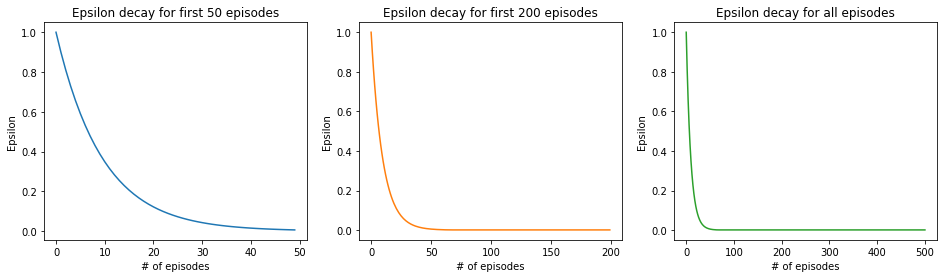

In [8]:
print("Epsilon for DQN: ", env.dqnAgent.epsilon_history)
history = env.dqnAgent.epsilon_history
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].plot(np.arange(len(history[:50])), history[:50])
axs[0].set_title('Epsilon decay for first 50 episodes')
axs[1].plot(np.arange(len(history[:200])), history[:200], 'tab:orange')
axs[1].set_title('Epsilon decay for first 200 episodes')
axs[2].plot(np.arange(len(history)), history, 'tab:green')
axs[2].set_title('Epsilon decay for all episodes')
for ax in axs:
  ax.set(xlabel = "# of episodes")
  ax.set(ylabel = "Epsilon")

DDQN

Epsilon for DDQN:  [1.0, 0.9, 0.81, 0.7290000000000001, 0.6561000000000001, 0.5904900000000002, 0.5314410000000002, 0.47829690000000014, 0.43046721000000016, 0.38742048900000015, 0.34867844010000015, 0.31381059609000017, 0.28242953648100017, 0.25418658283290013, 0.22876792454961012, 0.2058911320946491, 0.1853020188851842, 0.16677181699666577, 0.1500946352969992, 0.13508517176729928, 0.12157665459056936, 0.10941898913151243, 0.0984770902183612, 0.08862938119652508, 0.07976644307687257, 0.07178979876918531, 0.06461081889226679, 0.05814973700304011, 0.0523347633027361, 0.04710128697246249, 0.042391158275216244, 0.03815204244769462, 0.03433683820292516, 0.030903154382632643, 0.02781283894436938, 0.025031555049932444, 0.0225283995449392, 0.020275559590445278, 0.01824800363140075, 0.016423203268260675, 0.014780882941434608, 0.013302794647291147, 0.011972515182562033, 0.01077526366430583, 0.009697737297875247, 0.008727963568087723, 0.00785516721127895, 0.007069650490151055, 0.0063626854411359

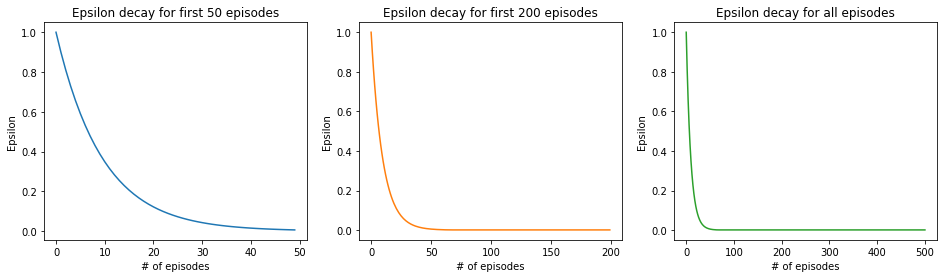

In [9]:
print("Epsilon for DDQN: ", denv.dqnAgent.epsilon_history)
history = denv.dqnAgent.epsilon_history
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].plot(np.arange(len(history[:50])), history[:50])
axs[0].set_title('Epsilon decay for first 50 episodes')
axs[1].plot(np.arange(len(history[:200])), history[:200], 'tab:orange')
axs[1].set_title('Epsilon decay for first 200 episodes')
axs[2].plot(np.arange(len(history)), history, 'tab:green')
axs[2].set_title('Epsilon decay for all episodes')
for ax in axs:
  ax.set(xlabel = "# of episodes")
  ax.set(ylabel = "Epsilon")

**Game score graphs**

Game score for DQN:  [11.0, 72.0, 21.0, 17.0, 21.0, 28.0, 12.0, 31.0, 14.0, 18.0, 11.0, 11.0, 13.0, 9.0, 10.0, 12.0, 8.0, 9.0, 10.0, 11.0, 10.0, 11.0, 12.0, 24.0, 19.0, 12.0, 10.0, 9.0, 12.0, 16.0, 16.0, 14.0, 13.0, 19.0, 12.0, 16.0, 20.0, 14.0, 12.0, 17.0, 34.0, 17.0, 11.0, 8.0, 8.0, 9.0, 10.0, 10.0, 9.0, 21.0, 20.0, 19.0, 15.0, 16.0, 14.0, 20.0, 25.0, 10.0, 12.0, 9.0, 10.0, 10.0, 9.0, 15.0, 13.0, 9.0, 11.0, 22.0, 16.0, 17.0, 18.0, 14.0, 17.0, 15.0, 15.0, 16.0, 12.0, 23.0, 9.0, 10.0, 10.0, 10.0, 9.0, 10.0, 22.0, 20.0, 17.0, 14.0, 30.0, 12.0, 26.0, 48.0, 17.0, 10.0, 19.0, 17.0, 26.0, 21.0, 26.0, 33.0, 18.0, 17.0, 45.0, 25.0, 49.0, 16.0, 25.0, 18.0, 23.0, 19.0, 49.0, 23.0, 24.0, 44.0, 35.0, 33.0, 70.0, 33.0, 33.0, 27.0, 28.0, 23.0, 29.0, 32.0, 37.0, 27.0, 21.0, 19.0, 258.0, 87.0, 33.0, 51.0, 36.0, 13.0, 59.0, 55.0, 51.0, 33.0, 61.0, 30.0, 40.0, 38.0, 23.0, 28.0, 51.0, 26.0, 47.0, 51.0, 36.0, 15.0, 94.0, 59.0, 55.0, 38.0, 45.0, 55.0, 46.0, 35.0, 39.0, 39.0, 58.0, 37.0, 22.0, 55.0, 54.0, 

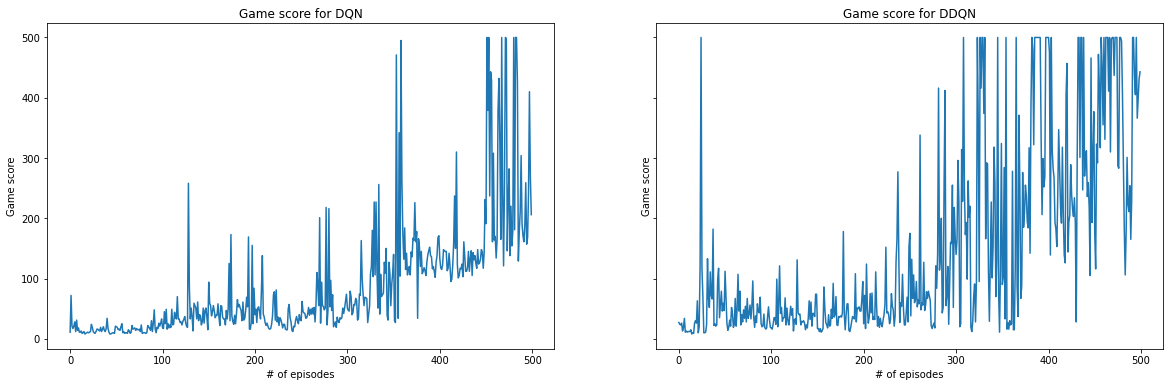

In [10]:
print("Game score for DQN: ", env.dqnAgent.reward_history)
print("Game score for DDQN: ", denv.dqnAgent.reward_history)
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
axs[0].plot(np.arange(len(env.dqnAgent.reward_history)), env.dqnAgent.reward_history)
axs[0].set_title('Game score for DQN')
axs[1].plot(np.arange(len(denv.dqnAgent.reward_history)), denv.dqnAgent.reward_history)
axs[1].set_title('Game score for DDQN')
for ax in axs:
  ax.set(xlabel = "# of episodes")
  ax.set(ylabel = "Game score")


**Average game score graphs**

Average Game score for DQN:  [18.4, 17.6, 16.8, 15.7, 14.1, 13.7, 11.5, 11.1, 10.4, 10.3, 10.3, 10.2, 11.7, 12.6, 12.6, 12.8, 12.8, 13.0, 13.5, 14.1, 14.4, 14.5, 14.0, 13.3, 13.7, 14.7, 15.2, 15.2, 15.3, 17.1, 17.4, 17.2, 16.1, 15.7, 15.0, 14.0, 13.6, 13.3, 13.7, 12.3, 12.5, 12.9, 13.7, 14.3, 15.4, 16.9, 16.9, 17.2, 16.0, 15.0, 14.1, 13.5, 13.4, 13.3, 12.2, 10.8, 12.0, 12.4, 13.2, 14.0, 14.4, 15.2, 15.2, 15.4, 16.1, 16.2, 16.3, 15.6, 14.9, 14.1, 13.7, 12.9, 12.4, 13.1, 13.5, 14.0, 13.1, 15.2, 15.4, 17.0, 20.8, 21.6, 21.6, 21.3, 21.0, 21.9, 22.6, 22.2, 24.3, 23.5, 20.4, 23.2, 24.7, 27.7, 27.6, 27.5, 27.2, 26.9, 25.5, 28.6, 29.2, 27.1, 29.0, 27.6, 29.3, 33.8, 35.3, 36.3, 37.1, 35.0, 35.0, 35.5, 34.3, 34.5, 33.9, 29.0, 27.6, 50.1, 56.1, 56.6, 59.4, 60.1, 58.2, 60.4, 63.2, 66.2, 67.6, 47.9, 42.2, 42.9, 41.6, 40.3, 41.8, 41.0, 38.1, 37.7, 39.5, 37.0, 35.5, 40.9, 43.0, 46.2, 47.2, 46.6, 49.5, 49.4, 47.8, 48.1, 50.5, 46.9, 44.7, 41.4, 43.1, 44.0, 42.1, 40.8, 40.6, 39.0, 39.8, 37.3, 38.6, 48.9

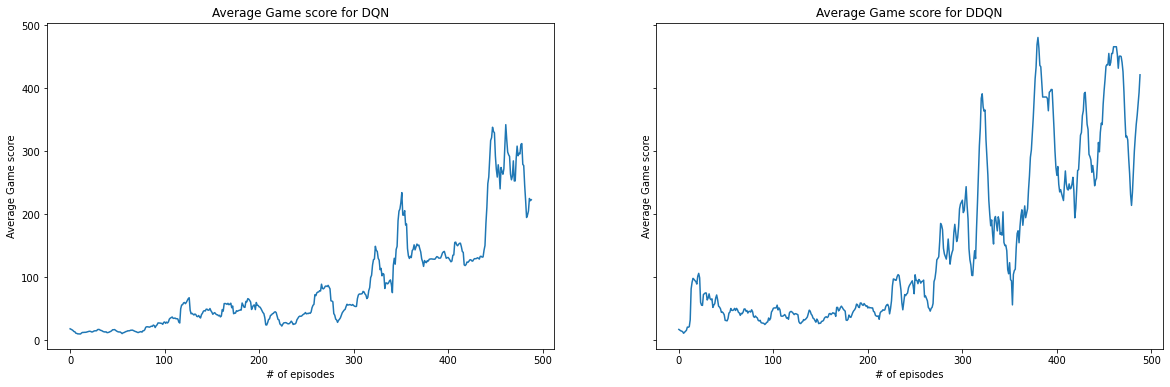

In [11]:
print("Average Game score for DQN: ", env.dqnAgent.average_reward_history)
print("Average Game score for DDQN: ", denv.dqnAgent.average_reward_history)
fig, axs = plt.subplots(1, 2, figsize=(20, 6),sharey=True)
axs[0].plot(np.arange(len(env.dqnAgent.average_reward_history)), env.dqnAgent.average_reward_history)
axs[0].set_title('Average Game score for DQN')
axs[1].plot(np.arange(len(denv.dqnAgent.average_reward_history)), denv.dqnAgent.average_reward_history)
axs[1].set_title('Average Game score for DDQN')
for ax in axs:
  ax.set(xlabel = "# of episodes")
  ax.set(ylabel = "Average Game score")